<a href="https://colab.research.google.com/github/ContiPaolo/Multifidelity-Tutorial/blob/main/MF_POD_Burger's1D.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Creation of the Multilevel dataset

Here we compute for each sample the coarse FEM solution that will then be given as imput to the NN of the fine level

#### Import libraries

In [1]:
import os
os.environ['OPENBLAS_NUM_THREADS'] = '1'
os.environ['OMP_NUM_THREADS'] = '1'
os.environ['KERAS_BACKEND'] = 'tensorflow'

import numpy as np
#import matplotlib as plt
from matplotlib import pyplot as plt
from itertools import product
import timeit

import pandas as pd 
from keras.optimizers import Adam,Nadam,Adamax
from keras.models import Model
from keras.layers import Input, Dense, LSTM, Dropout
from keras.models import Sequential
from keras.callbacks import LearningRateScheduler
from keras.models import load_model
from sklearn.utils import extmath
from fenics import *

from pyDOE import lhs as lhcs
from scipy.stats.distributions import norm as norm_dist

import sys
sys.path.append('../../solver')
from model import *
#######################     CONFIGURATIONS     ##########################
np.random.seed(123)
train = True
save = True

Generation of the datasets based on the quantities of interest 

In [2]:
# Resolution parameters
resolution_h1 = (100, 100)
resolution_h2 = (50, 50)
resolution_h3 = (25, 25)

# PDE parameters
field_mean = 1
field_stdev = 1
lamb_cov = 0.1
mkl = 64

# Set up the model(s)
solver_h1 = Model(resolution_h1, field_mean, field_stdev, mkl, lamb_cov)
solver_h2 = Model(resolution_h2, field_mean, field_stdev, mkl, lamb_cov)
solver_h3 = Model(resolution_h3, field_mean, field_stdev, 32, lamb_cov)

# Adjust the trasmissivity based on h1
list1 = solver_h1.solver.mesh.coordinates()
list2 = solver_h2.solver.mesh.coordinates()
list3 = solver_h3.solver.mesh.coordinates()

# Convert lists to numpy arrays if they are not already
array1 = np.array(list1)
array2 = np.array(list2)
array3 = np.array(list3)

# Convert to structured arrays for easy row-wise comparison
dtype = {'names': ['f{}'.format(i) for i in range(array1.shape[1])],
         'formats': [array1.dtype] * array1.shape[1]}

structured_array1 = array1.view(dtype)
structured_array2 = array2.view(dtype)
structured_array3 = array3.view(dtype)

# Create the boolean vector by checking if each row in array1 is in array2
bool_vector2 = np.in1d(structured_array1, structured_array2)
bool_vector3 = np.in1d(structured_array1, structured_array3)

# Set the trasmissivity field
solver_h2.random_process.eigenvalues = solver_h1.random_process.eigenvalues
solver_h2.random_process.eigenvectors = solver_h1.random_process.eigenvectors[bool_vector2]

solver_h3.random_process.eigenvalues = solver_h1.random_process.eigenvalues
solver_h3.random_process.eigenvectors = solver_h1.random_process.eigenvectors[bool_vector3]

2.251298741272782e+21
2.187679058454625e+20
4.998614104625165e+18


In [3]:
x_data = y_data = np.array([0.1, 0.3, 0.5, 0.7, 0.9])
datapoints = np.array(list(product(x_data, y_data)))

def solver_h1_data(x):
    solver_h1.solve(x)
    return solver_h1.get_data(datapoints)

def solver_h2_data(x):
    solver_h2.solve(x)
    return solver_h2.get_data(datapoints)

def solver_h3_data(x):
    solver_h3.solve(x)
    return solver_h3.get_data(datapoints)

Dataset generation: h1

In [4]:
# Set up an MLP trained on n_samples.
n_samples = 128000

# Create a matrix of random samples from a Gaussian Latin Hypercube.
samples = lhcs(64, samples = n_samples)
samples = norm_dist(loc=0, scale=1).ppf(samples)

data = np.zeros((n_samples, len(datapoints)))
for i in range(n_samples):
    data[i,:] = solver_h1_data(samples[i,:])

# Split the data into test and training data
X_train = samples[:int(0.9*n_samples),:]; y_train = data[:int(0.9*n_samples),:]
X_test  = samples[int(0.9*n_samples):,:]; y_test  = data[int(0.9*n_samples):,:]

np.savetxt("../../data/100-50-20/X_test_100resolution.csv",X_test , delimiter = ",")
np.savetxt("../../data/100-50-20/y_test_100resolution.csv",y_test , delimiter = ",")
np.savetxt("../../data/100-50-20/X_train_100resolution.csv",X_train , delimiter = ",")
np.savetxt("../../data/100-50-20/y_train_100resolution.csv",y_train , delimiter = ",")

In [5]:
# Set up an MLP trained on n_samples.
n_samples = 128000

# Create a matrix of random samples from a Gaussian Latin Hypercube.
samples = lhcs(64, samples = n_samples)
samples = norm_dist(loc=0, scale=1).ppf(samples)

data = np.zeros((n_samples, len(datapoints)))
for i in range(n_samples):
    data[i,:] = solver_h2_data(samples[i,:])

# Split the data into test and training data
X_train = samples[:int(0.9*n_samples),:]; y_train = data[:int(0.9*n_samples),:]
X_test  = samples[int(0.9*n_samples):,:]; y_test  = data[int(0.9*n_samples):,:]

np.savetxt("../../data/100-50-20/X_test_50resolution.csv",X_test , delimiter = ",")
np.savetxt("../../data/100-50-20/y_test_50resolution.csv",y_test , delimiter = ",")
np.savetxt("../../data/100-50-20/X_train_50resolution.csv",X_train , delimiter = ",")
np.savetxt("../../data/100-50-20/y_train_50resolution.csv",y_train , delimiter = ",")

In [6]:
# Set up an MLP trained on n_samples.
n_samples = 128000

# Create a matrix of random samples from a Gaussian Latin Hypercube.
samples = lhcs(64, samples = n_samples)
samples = norm_dist(loc=0, scale=1).ppf(samples)

data = np.zeros((n_samples, len(datapoints)))
for i in range(n_samples):
    data[i,:] = solver_h3_data(samples[i,:])

# Split the data into test and training data
X_train = samples[:int(0.9*n_samples),:]; y_train = data[:int(0.9*n_samples),:]
X_test  = samples[int(0.9*n_samples):,:]; y_test  = data[int(0.9*n_samples):,:]

np.savetxt("../../data/100-50-20/X_test_20resolution.csv",X_test , delimiter = ",")
np.savetxt("../../data/100-50-20/y_test_20resolution.csv",y_test , delimiter = ",")
np.savetxt("../../data/100-50-20/X_train_20resolution.csv",X_train , delimiter = ",")
np.savetxt("../../data/100-50-20/y_train_20resolution.csv",y_train , delimiter = ",")

# POD dataset generation

In [7]:
x_data = y_data = np.linspace(0.0, 1.0, 10)
datapoints = np.array(list(product(x_data, y_data)))

def solver_h1_data(x):
    solver_h1.solve(x)
    return solver_h1.get_data(datapoints)

def solver_h2_data(x):
    solver_h2.solve(x)
    return solver_h2.get_data(datapoints)

def solver_h3_data(x):
    solver_h3.solve(x)
    return solver_h3.get_data(datapoints)

[0.62429625 0.67308696 0.70635168 0.73231928 0.75541301 0.77122986
 0.78626546 0.7999382  0.81350078 0.82420505 0.83465693 0.84478197
 0.85276603 0.86048674 0.8679012  0.87488353 0.88163056 0.88788758
 0.89361023 0.89929785 0.90409998 0.90871676 0.91328372 0.91781456
 0.9221533  0.9261337  0.92991247 0.93342321 0.93662355 0.93977291
 0.94285461 0.94588133 0.94866549 0.95144387 0.95416573 0.95655156
 0.95889138 0.96113886 0.96335971 0.96553926 0.96763314 0.96952962
 0.97140894 0.97316582 0.97488033 0.97657123 0.97823101 0.97966437
 0.98109296 0.98227533 0.98341239 0.98446969 0.98551799 0.98651725
 0.98739966 0.98823975 0.9890205  0.9897623  0.99046265 0.9910921
 0.99170115 0.99230399 0.9928633  0.99338366 0.99388953 0.99434953
 0.9948012  0.9952493  0.99568406 0.99611561] .....


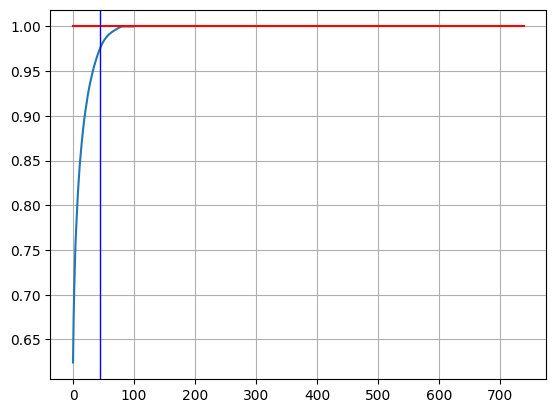

In [8]:
N = 128000
n_datapoints = len(datapoints)

coarse_sol_train = np.zeros((int(N*0.9), n_datapoints))
for i in range( int(N*0.9) ):
    coarse_sol_train[i, :] = solver_h1_data(X_train[i, :])

coarse_sol_test = np.zeros((int(N*0.1), n_datapoints))
for i in range( int(N*0.1) ):
    coarse_sol_test[i, :] = solver_h1_data(X_test[i, :])

n = 15000
y_t = coarse_sol_train[0:n,:].T
y_t.shape

U, S, Vh = np.linalg.svd(y_t)
U.shape, S.shape, Vh.shape

#print('S is:', S)
v = np.cumsum(S)/np.sum(S)
print(v[0:70], '.....')
plt.plot(v, '-')
plt.grid()
plt.plot(np.ones(740), 'red')
plt.axvline(x=45, color='b', linestyle='-', linewidth=1)
plt.show()

In [9]:
#########################   PROJECTION ONTO POD BASIS    ##########################
n_comp = 45 # number of components to retain 

basis = U[:,0:n_comp]
X_train_pod = coarse_sol_train @ basis
X_test_pod = coarse_sol_test @ basis

np.savetxt("../../data/100-50-20/X_train_100resolution_pod.csv",X_train_pod , delimiter = ",")
np.savetxt("../../data/100-50-20/X_test_100resolution_pod.csv",X_test_pod , delimiter = ",")
np.savetxt("../../data/100-50-20/POD_basis_100resolution.csv", basis, delimiter=',')

[0.6262624  0.67514848 0.70843327 0.73443556 0.7575336  0.7733525
 0.78837323 0.80201645 0.81554784 0.82622134 0.83663703 0.84670772
 0.85463405 0.86231632 0.86968763 0.87660975 0.88329015 0.88950971
 0.89518971 0.90079389 0.90554558 0.9101111  0.9146391  0.91913288
 0.92340906 0.92732953 0.93106192 0.9345414  0.93769786 0.94079649
 0.94383074 0.94680444 0.94955724 0.95229265 0.95497701 0.95733431
 0.9596335  0.9618342  0.96400722 0.96615149 0.96821001 0.97007289
 0.97192503 0.97364777 0.97533095 0.9769864  0.97860335 0.98001115
 0.98140298 0.98257215 0.98369036 0.98472228 0.98574816 0.98673504
 0.98760111 0.98843179 0.9892039  0.9899321  0.99062202 0.99124161
 0.99183891 0.9924305  0.99298148 0.99349366 0.99399021 0.99444173
 0.99488546 0.9953262  0.99575519 0.99618085] .....


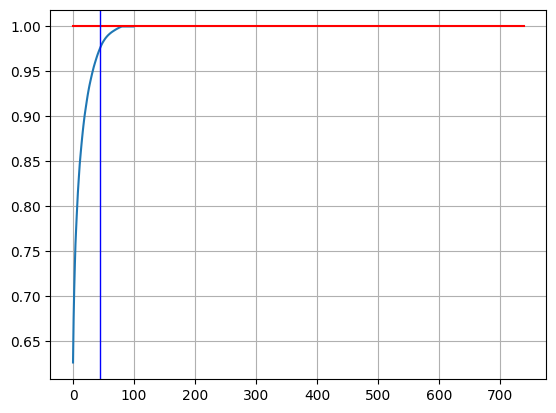

In [10]:
N = 128000
n_datapoints = len(datapoints)

coarse_sol_train = np.zeros((int(N*0.9), n_datapoints))
for i in range( int(N*0.9) ):
    coarse_sol_train[i, :] = solver_h2_data(X_train[i, :])

coarse_sol_test = np.zeros((int(N*0.1), n_datapoints))
for i in range( int(N*0.1) ):
    coarse_sol_test[i, :] = solver_h2_data(X_test[i, :])

n = 15000
y_t = coarse_sol_train[0:n,:].T
y_t.shape

U, S, Vh = np.linalg.svd(y_t)
U.shape, S.shape, Vh.shape

#print('S is:', S)
v = np.cumsum(S)/np.sum(S)
print(v[0:70], '.....')
plt.plot(v, '-')
plt.grid()
plt.plot(np.ones(740), 'red')
plt.axvline(x=45, color='b', linestyle='-', linewidth=1)
plt.show()

In [11]:
#########################   PROJECTION ONTO POD BASIS    ##########################
n_comp = 45 # number of components to retain 

basis = U[:,0:n_comp]
X_train_pod = coarse_sol_train @ basis
X_test_pod = coarse_sol_test @ basis

np.savetxt("../../data/100-50-20/X_train_50resolution_pod.csv",X_train_pod , delimiter = ",")
np.savetxt("../../data/100-50-20/X_test_50resolution_pod.csv",X_test_pod , delimiter = ",")
np.savetxt("../../data/100-50-20/POD_basis_50resolution.csv", basis, delimiter=',')

[0.63412922 0.68340634 0.71677719 0.7428785  0.76595206 0.78173645
 0.79666931 0.81017944 0.82361988 0.83415639 0.84444737 0.85432724
 0.86207259 0.86959465 0.87679273 0.88355134 0.89004093 0.89608915
 0.90163993 0.90696279 0.91153661 0.91590821 0.92025574 0.92458031
 0.92868522 0.9323872  0.93591472 0.93924752 0.94224199 0.94510571
 0.94788454 0.95064451 0.95324653 0.95580192 0.95826586 0.9604666
 0.96263887 0.96465761 0.96664818 0.96859    0.97050201 0.97224026
 0.97395056 0.97553435 0.97708983 0.97861757 0.9800475  0.98134826
 0.98260172 0.98371429 0.98475356 0.98571634 0.98667371 0.98760142
 0.98841557 0.98918103 0.98990259 0.99059443 0.99125057 0.99181974
 0.99236643 0.99290648 0.9934282  0.99393149 0.99439226 0.99481434
 0.99523098 0.99564295 0.99604707 0.99644793] .....


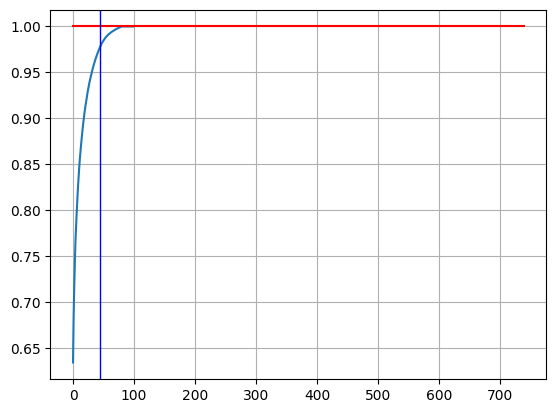

In [14]:
N = 128000
n_datapoints = len(datapoints)

coarse_sol_train = np.zeros((int(N*0.9), n_datapoints))
for i in range( int(N*0.9) ):
    coarse_sol_train[i, :] = solver_h3_data(X_train[i, :])

coarse_sol_test = np.zeros((int(N*0.1), n_datapoints))
for i in range( int(N*0.1) ):
    coarse_sol_test[i, :] = solver_h3_data(X_test[i, :])

n = 15000
y_t = coarse_sol_train[0:n,:].T
y_t.shape

U, S, Vh = np.linalg.svd(y_t)
U.shape, S.shape, Vh.shape

#print('S is:', S)
v = np.cumsum(S)/np.sum(S)
print(v[0:70], '.....')
plt.plot(v, '-')
plt.grid()
plt.plot(np.ones(740), 'red')
plt.axvline(x=45, color='b', linestyle='-', linewidth=1)
plt.show()

In [13]:
#########################   PROJECTION ONTO POD BASIS    ##########################
n_comp = 45 # number of components to retain 

basis = U[:,0:n_comp]
X_train_pod = coarse_sol_train @ basis
X_test_pod = coarse_sol_test @ basis

np.savetxt("../../data/100-50-20/X_train_20resolution_pod.csv",X_train_pod , delimiter = ",")
np.savetxt("../../data/100-50-20/X_test_20resolution_pod.csv",X_test_pod , delimiter = ",")
np.savetxt("../../data/100-50-20/POD_basis_20resolution.csv", basis, delimiter=',')